Develop a multi-layer perceptron with three hidden layers (you pick the dimensions of the hidden layers) for the CIFAR-10 dataset.

1.a. Train the model from scratch (with randomized parameters) and plot the results (training loss and accuracy, validation accuracy) after 20 epochs. Does your network need more epochs for full training? Do you observe overfitting? Make sure to save the trained parameters and model. Report and plot your training and validation results. Report precision, recall, F1 score, and confusion matrix. (25pt)5pt)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import random
import numpy as np


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [3]:
sample_image, sample_label = train_dataset[0]
print("image size :", sample_image.size())
print(sample_label)

image size : torch.Size([3, 32, 32])
6


In [4]:
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [16]:
class CIFAR10(nn.Module):
    def __init__(self):
        super(CIFAR10, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3*32*32, 128)  
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)  

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


Epoch 1/20, Training Loss: 1.785279278868067, Evaluation Loss: 1.6309287784198603
Epoch 2/20, Training Loss: 1.5767904245845796, Evaluation Loss: 1.5328961317531598
Epoch 3/20, Training Loss: 1.4937726576131503, Evaluation Loss: 1.478349565697935
Epoch 4/20, Training Loss: 1.434451599992092, Evaluation Loss: 1.4472801620586992
Epoch 5/20, Training Loss: 1.386217462009752, Evaluation Loss: 1.4316172677868853
Epoch 6/20, Training Loss: 1.34458524694217, Evaluation Loss: 1.4052183052983147
Epoch 7/20, Training Loss: 1.3081671113931286, Evaluation Loss: 1.3936493771906477
Epoch 8/20, Training Loss: 1.2768254471145528, Evaluation Loss: 1.374523091240051
Epoch 9/20, Training Loss: 1.2479661287440753, Evaluation Loss: 1.3741090752827092
Epoch 10/20, Training Loss: 1.2201755544503226, Evaluation Loss: 1.3815695382535649
Epoch 11/20, Training Loss: 1.1955700379034226, Evaluation Loss: 1.378175235213563
Epoch 12/20, Training Loss: 1.1712100433372796, Evaluation Loss: 1.3785703915376633
Epoch 13/

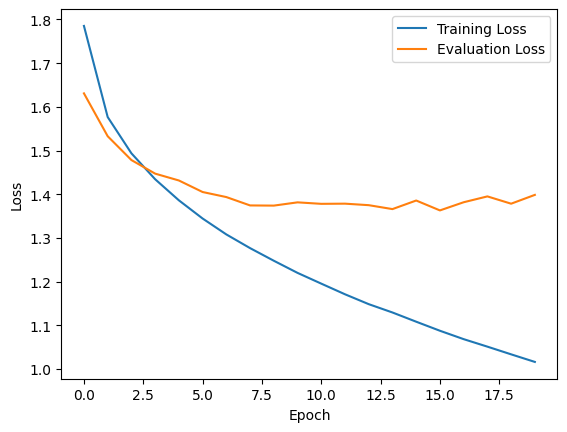

In [20]:
model = CIFAR10().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Number of epochs
num_epochs = 20

# Lists to store training and evaluation loss for each epoch
train_losses = []
eval_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for inputs, targets in train_loader:
        # Move data to GPU
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Average training loss for the epoch
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation loop (assuming you have a validation set)
    model.eval()
    eval_loss = 0.0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            eval_loss += loss.item()

    # Average evaluation loss for the epoch
    avg_eval_loss = eval_loss / len(test_loader)
    eval_losses.append(avg_eval_loss)

    # Print training and evaluation progress
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss}, Evaluation Loss: {avg_eval_loss}')

# Plotting the losses
plt.plot(train_losses, label='Training Loss')
plt.plot(eval_losses, label='Evaluation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
torch.save(model.state_dict(), 'cifar10_model.pth')


In [22]:
from sklearn.metrics import confusion_matrix, classification_report
model = CIFAR10().to(device)
model.load_state_dict(torch.load('cifar10_model.pth'))
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)
        
        # Get predictions
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_targets, all_preds)

# Calculate precision, recall, and F1 score
report = classification_report(all_targets, all_preds, target_names=[str(i) for i in range(10)])

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(report)

Confusion Matrix:
[[625  44  51  28  28  14  26  22 127  35]
 [ 40 677  19  29  11   8  19  18  76 103]
 [ 90  14 405 100 168  61  63  63  24  12]
 [ 37  23  88 411  86 137  92  69  23  34]
 [ 54   9 126  61 524  40  67  86  22  11]
 [ 20  11  92 281  77 357  45  68  17  32]
 [  7  14  84 153 150  26 507  22  20  17]
 [ 50  11  45  78 106  73  18 567  12  40]
 [114  76  19  27  24  15   9  13 662  41]
 [ 49 221  17  46  12  16  14  52  71 502]]

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.62      0.60      1000
           1       0.62      0.68      0.64      1000
           2       0.43      0.41      0.42      1000
           3       0.34      0.41      0.37      1000
           4       0.44      0.52      0.48      1000
           5       0.48      0.36      0.41      1000
           6       0.59      0.51      0.55      1000
           7       0.58      0.57      0.57      1000
           8       0.63      0.66      0

1.b. Explore the complexity of the network by increasing its width and depth. How do the training and validation results change? Compare them against the baseline. Do you see any overfitting? (25pt)

In [5]:
class Depth_CIFAR10(nn.Module):
    def __init__(self):
        super(Depth_CIFAR10, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3*32*32, 512)  
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512,128)
        self.fc3 = nn.Linear(128, 10)  

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

Epoch 1/20, Training Loss: 1.9125304784213437, Evaluation Loss: 1.6941867602138092
Epoch 2/20, Training Loss: 1.61975080777801, Evaluation Loss: 1.5506271554258304
Epoch 3/20, Training Loss: 1.5022227732096431, Evaluation Loss: 1.4786276040366664
Epoch 4/20, Training Loss: 1.4169214892219597, Evaluation Loss: 1.4395193379527083
Epoch 5/20, Training Loss: 1.3475222527332513, Evaluation Loss: 1.3967180669117278
Epoch 6/20, Training Loss: 1.2877072350229883, Evaluation Loss: 1.3647500908793733
Epoch 7/20, Training Loss: 1.2332110839704635, Evaluation Loss: 1.3576151366812734
Epoch 8/20, Training Loss: 1.1864092527332781, Evaluation Loss: 1.3352892932038718
Epoch 9/20, Training Loss: 1.1389840881716191, Evaluation Loss: 1.3271545325986112
Epoch 10/20, Training Loss: 1.0956521010978513, Evaluation Loss: 1.3172840656944738
Epoch 11/20, Training Loss: 1.0512775247553108, Evaluation Loss: 1.3014493727455505
Epoch 12/20, Training Loss: 1.010915152037365, Evaluation Loss: 1.4059911065589126
Epoc

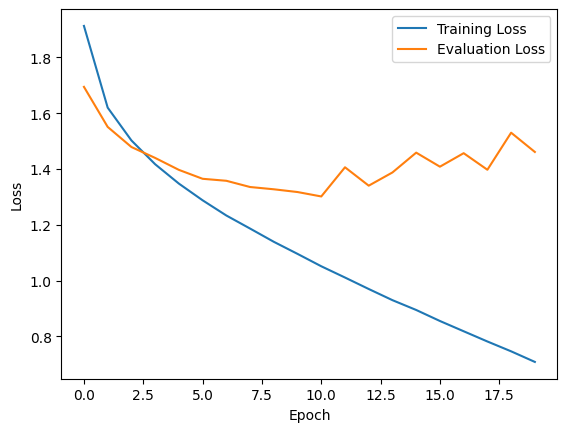

In [8]:
model = Depth_CIFAR10().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Number of epochs
num_epochs = 20

# Lists to store training and evaluation loss for each epoch
train_losses = []
eval_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for inputs, targets in train_loader:
        # Move data to GPU
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Average training loss for the epoch
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation loop (assuming you have a validation set)
    model.eval()
    eval_loss = 0.0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            eval_loss += loss.item()

    # Average evaluation loss for the epoch
    avg_eval_loss = eval_loss / len(test_loader)
    eval_losses.append(avg_eval_loss)

    # Print training and evaluation progress
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss}, Evaluation Loss: {avg_eval_loss}')

# Plotting the losses
plt.plot(train_losses, label='Training Loss')
plt.plot(eval_losses, label='Evaluation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
torch.save(model.state_dict(), 'depth_cifar10_model.pth')


In [10]:
from sklearn.metrics import confusion_matrix, classification_report
model = Depth_CIFAR10().to(device)
model.load_state_dict(torch.load('depth_cifar10_model.pth'))
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)
        
        # Get predictions
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_targets, all_preds)

# Calculate precision, recall, and F1 score
report = classification_report(all_targets, all_preds, target_names=[str(i) for i in range(10)])

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(report)

Confusion Matrix:
[[635  23  45  21  33  15  25  37 118  48]
 [ 40 587  11  38  13  13  23  25 125 125]
 [ 72   9 374 121 147  82  86  70  28  11]
 [ 28  15  51 466  58 167  98  71  25  21]
 [ 39   5  85  96 489  62  87 100  27  10]
 [ 14   5  54 292  76 388  55  79  18  19]
 [  9   7  38 107  95  45 654  15  20  10]
 [ 33   8  30  81  67  73  28 641  18  21]
 [119  46  11  36  17  16   6  17 696  36]
 [ 54 138   7  45  12  18  27  61 105 533]]

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.64      0.62      1000
           1       0.70      0.59      0.64      1000
           2       0.53      0.37      0.44      1000
           3       0.36      0.47      0.40      1000
           4       0.49      0.49      0.49      1000
           5       0.44      0.39      0.41      1000
           6       0.60      0.65      0.63      1000
           7       0.57      0.64      0.61      1000
           8       0.59      0.70      0